### NLP GENRE PREDICTION DEMO

* Train NLP models: Naive Bayes, Logistic Regression and SVM
* Train Ensemble model: Gradient Boosting Classifier on sample training data
* Pick a few shows, run descriptions through cleaning and make predictions

In [9]:
import time

import matplotlib.pyplot as plt
from  matplotlib import ticker 
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB

from genre_tagging import ETL, TfIdfVec, NLPModels, utils

sns.set_style('whitegrid')

In [3]:
# training data that has been preprocessed
file_source = './data/training_data_02062023.csv'

In [6]:
df = pd.read_csv(file_source, index_col=0)

In [28]:
# training sample has ~50k shows
df.shape

(50101, 11)

In [7]:
df.head()

,emx_id,tmdb_id,show_name,genre,content_type,overview,tokens,token_str,genre_split,n_genres,genre_1
0,26299,13624,First Love,talk-show,TV,first love is an american soap opera which ran...,"['first', 'love', 'american', 'soap', 'opera',...",first love american soap opera ran nbc daytime...,['talk-show'],1,talk-show
1,26300,36842,First Love,drama,TV,first love is a south korean television series...,"['first', 'love', 'south', 'korean', 'televisi...",first love south korean television series star...,['drama'],1,drama
2,26301,28469,First Love,drama,TV,kasumi is shocked to discover that her older s...,"['kasumi', 'shocked', 'discover', 'older', 'si...",kasumi shocked discover older sisters fiance m...,['drama'],1,drama
3,26302,68764,First Love,drama|family,TV,they say absence makes the heart grow fonder z...,"['say', 'absence', 'makes', 'heart', 'grow', '...",say absence makes heart grow fonder zuo zai ju...,"['drama', 'family']",2,drama
4,26303,129128,First Love Again,drama|science fiction,TV,in the year 2019 eminent physicist ye you ning...,"['year', 'eminent', 'physicist', 'ye', 'ning',...",year eminent physicist ye ning travels back ho...,"['drama', 'science fiction']",2,drama


In [29]:
# check for missing values - need to be removed
df.isnull().sum()

emx_id           0
tmdb_id          0
show_name        0
genre            0
content_type     0
overview         0
tokens           0
token_str       14
genre_split      0
n_genres         0
genre_1          0
dtype: int64

In [30]:
# drop nulls
df = df[~df.token_str.isnull()]

In [31]:
# ~50k rows in this demo
df.shape

(50087, 11)

In [32]:
df.genre_1.value_counts()

genre_1
drama                 10824
comedy                10601
documentary            8803
animation              5459
action                 4855
reality                3511
crime                  2991
news                    806
talk-show               739
science fiction         691
family                  523
western                 120
sports                   90
music                    42
game-show                28
entertainment news        3
romance                   1
Name: count, dtype: int64

/var/folders/y4/8c0n8_2x5fq9rd9gn92lqkvm0000gn/T/ipykernel_1515/2221837456.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(df.genre_1.value_counts(), palette='Set1', ax=ax)
/var/folders/y4/8c0n8_2x5fq9rd9gn92lqkvm0000gn/T/ipykernel_1515/2221837456.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels=labels, rotation=45)


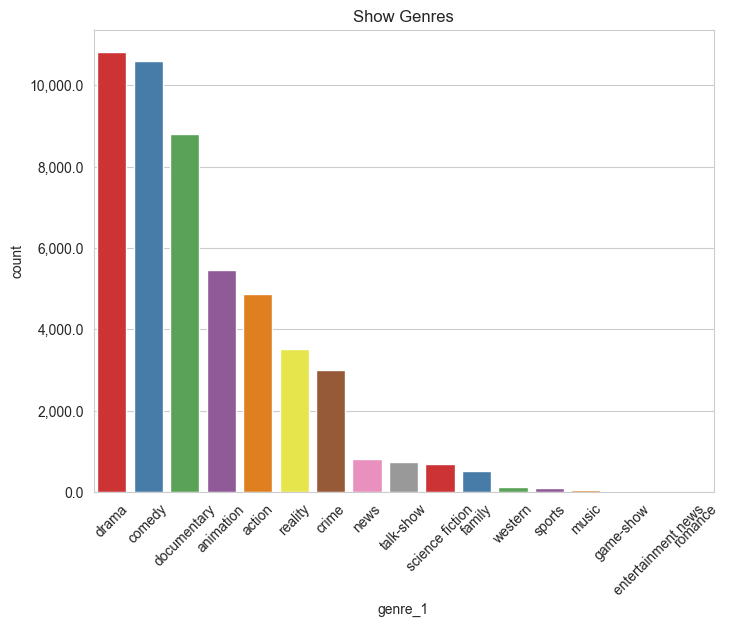

In [210]:
# plot genres
fig, ax = plt.subplots(figsize=(8,6))
g = sns.barplot(df.genre_1.value_counts(), palette='Set1', ax=ax)
labels = [i.get_text() for i in ax.get_xticklabels()]
_ = ax.set_xticklabels(labels=labels, rotation=45)
_ = ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(x, ',')))
_ = ax.set_title('Show Genres')

### MODEL TRAINING

In [34]:
# assign X & y
X = df.token_str.copy()
y = df.genre_1.copy()

In [37]:
# create TFIDF matrix
tf_vec = TfIdfVec.TfIdfVec(X_train=X)
vec = {'vectorizer': tf_vec.tf_vec}
X_matrix = tf_vec.train_tfidf()

In [40]:
# X_matrix has the same size as our corpus
X_matrix

<50087x107900 sparse matrix of type '<class 'numpy.float64'>'
	with 1486688 stored elements in Compressed Sparse Row format>

In [44]:
# create models: Naive Bayes, Logistic Regression, SVM

# create Naive Bayes model
nb = NLPModels.NLPModels(model=MultinomialNB(), model_name='NB')

# train Naive Bayes model
nb_start = time.time()
nb.train_model(X_matrix, y, **vec)
nb_end = time.time()
print(f"Naive Bayes model training took {np.round((nb_end - nb_start) / 60.0, 2)} mins")

# make predictions on training data to get idea of performance
nb_pred = nb.predict(X)
print(f"{nb.model_name} score on training data: {NLPModels.get_score(y_true=y, y_pred=nb_pred)}")

# create Logistic Regression model
lg = NLPModels.NLPModels(model=LogisticRegression(multi_class='multinomial', penalty='l2', max_iter=1000),
                model_name='LG')
# train Logistic Regression model & make predictions
lg_start = time.time()
lg.train_model(X_matrix, y, **vec)
lg_end = time.time()
print(f"Logistic Regression model training took {np.round((lg_end - lg_start) / 60.0, 2)} mins")

# LG predictions
lg_pred = lg.predict(X)
print(f"{lg.model_name} score on training data: {NLPModels.get_score(y_true=y, y_pred=lg_pred)}")

# create SVM model
svm = NLPModels.NLPModels(model=SGDClassifier(penalty='l2', max_iter=1000), model_name='SVM')

# train SVM model
svm_start = time.time()
svm.train_model(X_matrix, y, **vec)
svm_end = time.time()
print(f"SVM model training took {np.round((svm_end - svm_start) / 60.0, 2)} mins")

# SVM predictions
svm_pred = svm.predict(X)
print(f"{svm.model_name} score on training data: {NLPModels.get_score(y_true=y, y_pred=svm_pred)}")


# encode predictions to use in ensemble classifier
df_model = pd.DataFrame(map(lambda x: utils.encode_genres(x, ETL.inverse_genre_dict), [nb_pred, lg_pred, svm_pred])).T
df_model.columns = ['nb', 'lg', 'svm']
y_labels = utils.encode_genres(y, ETL.inverse_genre_dict)


Naive Bayes model training took 0.01 mins
NB score on training data: 0.5755185976401063
Logistic Regression model training took 5.24 mins
LG score on training data: 0.7761494998702259
SVM model training took 0.02 mins
SVM score on training data: 0.7691616587138379


### ENSEMBLE MODEL: GRADIENT BOOSTING CLASSIFIER

In [160]:
# Gradient Boosting classifier ensemble
# find best paramters
bg = NLPModels.NLPModels(model=GradientBoostingClassifier(n_estimators=200, verbose=1, learning_rate=0.01),
                        model_name='GradientBoosting')

n_trees = [50, 100, 200]
learning_rates = [0.1, 0.5, 0.01, 0.05, 0.025]
param_search = {'n_estimators': n_trees, 'learning_rate': learning_rates}

tuning_start = time.time()
bg.tune_params(df_model, y, **param_search)
tuning_end = time.time()
print(f"BG parameter tuning {np.round((tuning_end - tuning_start) / 60.0, 2)} mins")



/Users/gabyagrocostea/dev/EMX/nlp_genres/genre_tagging_venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.5760           10.62s
         2   975282643.7974            8.80s
         3   991529339.7801            8.09s
         4   991529339.6862            7.67s
         5   991529339.6165            7.36s
         6   991529339.5631            7.10s
         7   991529339.5207            6.84s
         8   991529339.4885            6.59s
         9   991529339.4627            6.40s
        10   991529339.4425            6.22s
        20   991529339.3672            4.54s
        30   991529339.3521            3.25s
        40   991529339.3462            1.61s
        50   991529339.3419            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.5884            6.25s
         2  1570111686.7239            6.18s
         3 11066027601482657567750714556416.0000            6.37s
         4 11066027601482657567750714556416.0000            6.19s
         5 11066027601482657567750714556416.0000        

In [209]:
# train Ensemble
bg_start = time.time()
bg.train_model(df_model.values, y_labels)
bg_end = time.time()
print(f"Gradient Boosting model training took {np.round((bg_end - bg_start) / 60.0, 2)} mins")
# Ensemble training predictions
bg_pred = bg.predict(df_model)
print(f"{bg.model_name} score on training data: {NLPModels.get_score(y_true=y_labels, y_pred=bg_pred)}")

# return dictionary of trained models
model_dict = {'nb': nb, 'lg': lg, 'svm': svm, 'bg': bg}

      Iter       Train Loss   Remaining Time 
         1           1.9907            1.09m
         2           1.9456           55.14s
         3           1.9053           50.92s
         4           1.8685           49.30s
         5           1.8343           48.24s
         6           1.8021           46.98s
         7           1.7720           45.96s
         8           1.7433           45.31s
         9           1.7163           45.29s
        10           1.6906           45.15s
        20           1.4852           44.96s
        30           1.3411           43.20s
        40           1.2340           39.89s
        50           1.1521           37.42s
        60           1.0884           36.53s
        70           1.0385           34.64s
        80           0.9991           32.42s
        90           0.9678           29.24s
       100           0.9426           26.52s
       200           0.8487            0.00s
Gradient Boosting model training took 0.85 mins


/Users/gabyagrocostea/dev/EMX/nlp_genres/genre_tagging_venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


GradientBoosting score on training data: 0.8000678818855192


### SAMPLE SHOWS: MAKE GENRE PREDICTIONS

In [143]:
df_test = pd.DataFrame(data = 
                       [
  {
    "show_name": "NCIS",
    "overview": "From murder and espionage to terrorism and stolen submarines, a team of special agents investigates any crime that has a shred of evidence connected to Navy and Marine Corps personnel, regardless of rank or position."
  },
  {
    "show_name": "Love is Blind",
    "overview": "Singles seeking romance go on a series of blind dates without seeing each other. They must decide if they want to get engaged solely based on emotional connections, leading to dramatic and heartfelt moments."
  },
  {
    "show_name": "Nobody Wants This",
    "overview": "In a world where forgotten ideas come to life, rejected concepts band together in a humorous yet touching quest to prove their worth, facing creative rejection and forming unexpected alliances."
  },
  {
    "show_name": "Beef",
    "overview": "A road rage incident sparks an escalating feud between two strangers, leading to unpredictable confrontations and revealing dark, humorous aspects of their personal lives as they spiral into obsession."
  },
  {
    "show_name": "The Crown",
    "overview": "A historical drama following the reign of Queen Elizabeth II, exploring the personal, political, and societal challenges faced by the British royal family over the decades."
  }
])

In [144]:
df_test

,show_name,overview
0,NCIS,From murder and espionage to terrorism and sto...
1,Love is Blind,Singles seeking romance go on a series of blin...
2,Nobody Wants This,"In a world where forgotten ideas come to life,..."
3,Beef,A road rage incident sparks an escalating feud...
4,The Crown,A historical drama following the reign of Quee...


In [145]:
# Preprocess data
etl = ETL.ETL()
etl.data = df_test.copy()
etl.clean_new_data()

In [146]:
# we can see that stop words have been removed and everything is lowercase in token_str column
etl.data

,show_name,overview,tokens,token_str
0,NCIS,From murder and espionage to terrorism and sto...,"[murder, espionage, terrorism, stolen, submari...",murder espionage terrorism stolen submarines t...
1,Love is Blind,Singles seeking romance go on a series of blin...,"[singles, seeking, romance, go, series, blind,...",singles seeking romance go series blind dates ...
2,Nobody Wants This,"In a world where forgotten ideas come to life,...","[world, forgotten, ideas, come, life, rejected...",world forgotten ideas come life rejected conce...
3,Beef,A road rage incident sparks an escalating feud...,"[road, rage, incident, sparks, escalating, feu...",road rage incident sparks escalating feud stra...
4,The Crown,A historical drama following the reign of Quee...,"[historical, drama, following, reign, queen, e...",historical drama following reign queen elizabe...


In [147]:
# set up X 
new_X = etl.data.token_str



In [148]:
# make predictions for individual models
nb_new_pred, lg_new_pred, svm_new_pred = nb.predict(new_X), lg.predict(new_X), svm.predict(new_X)

In [149]:
# model predictions
print(f"NB pred {nb_new_pred}, LG pred {lg_new_pred}, SMV pred {svm_new_pred}")

NB pred ['documentary' 'drama' 'comedy' 'drama' 'documentary'], LG pred ['crime' 'drama' 'comedy' 'documentary' 'documentary'], SMV pred ['crime' 'reality' 'comedy' 'documentary' 'documentary']


In [150]:
# combine results from each model
results = pd.DataFrame(zip(df_test.show_name, nb_new_pred), columns=['show_name','nb'])
results = results.assign(lg = lg_new_pred, svm = svm_new_pred)
results

,show_name,nb,lg,svm
0,NCIS,documentary,crime,crime
1,Love is Blind,drama,drama,reality
2,Nobody Wants This,comedy,comedy,comedy
3,Beef,drama,documentary,documentary
4,The Crown,documentary,documentary,documentary


In [151]:
# encode predictions to use in ensemble classifier
encoded_pred = pd.DataFrame(map(lambda x: ETL.encode_genres(x, ETL.inverse_genre_dict), [nb_new_pred, lg_new_pred, svm_new_pred])).T
encoded_pred.columns = ['nb', 'lg', 'svm']
y_labels = ETL.encode_genres(y, ETL.inverse_genre_dict)


In [152]:
# these are now numeric so ensemble model can use input
encoded_pred

,nb,lg,svm
0,4,3,3
1,5,5,11
2,2,2,2
3,5,4,4
4,4,4,4


In [153]:
# make predictions using trained ensemble
bg_new_pred = bg.predict(encoded_pred)

/Users/gabyagrocostea/dev/EMX/nlp_genres/genre_tagging_venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [154]:
# ensemble preditions
bg_new_pred

array([ 3, 11,  2,  4,  4])

In [212]:
# assign final prediction column
results = results.assign(predicted_genre = [ETL.genre_dict[i] for i in bg_new_pred])

In [220]:
results

,show_name,nb,lg,svm,predicted_genre
0,NCIS,documentary,crime,crime,crime
1,Love is Blind,drama,drama,reality,reality
2,Nobody Wants This,comedy,comedy,comedy,comedy
3,Beef,drama,documentary,documentary,documentary
4,The Crown,documentary,documentary,documentary,documentary
